In [1]:
# Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

In [2]:
# Create function for confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normazilation can be apploed by setting 'normalize=True'
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without Normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
# Load in the data
data = tf.keras.datasets.cifar10
(X_train_raw, y_train), (X_test_raw, y_test) = data.load_data()

In [4]:
# Scale the data to 0-1
X_train = X_train_raw / 255.0
X_test = X_test_raw / 255.0

In [5]:
# Flatten the labels (just to get it in the right format)
y_train, y_test = y_train.flatten(), y_test.flatten()

In [6]:
print(X_train.shape)

(50000, 32, 32, 3)


In [7]:
print(y_train.shape)

(50000,)


In [8]:
# Print the number of classes
K = len(set(y_train))
print('Number of classes:', K)

Number of classes: 10


In [9]:
# Define the layers - this architecture takes inspiration from the VGG architecture
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3,3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

In [10]:
# Create the model
model = Model(i, x)

In [11]:
# Define how the model should be trained
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Create a learning rate scheduler
def schedule(epoch, lr):
    print('Learning Rate:', lr)
    return lr * 0.9
    
# Use the scheduler
scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)

In [13]:
# Train the model with data augmentation
# Create data generator
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, 
                                                                 height_shift_range=0.1, 
                                                                 horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

# Fit the model
result = model.fit(train_generator,
                   validation_data=(X_test, y_test),
                   steps_per_epoch = steps_per_epoch,
                   epochs=30, callbacks=[scheduler])

Train for 1562 steps, validate on 10000 samples
Learning Rate: 0.0010000000474974513
Epoch 1/30
1562/1562 [==============================] - 29s 18ms/step - loss: 1.4248 - accuracy: 0.4869 - val_loss: 1.1872 - val_accuracy: 0.5898
Learning Rate: 0.0009000000427477062
Epoch 2/30
1562/1562 [==============================] - 27s 17ms/step - loss: 1.0104 - accuracy: 0.6452 - val_loss: 0.7954 - val_accuracy: 0.7216
Learning Rate: 0.0008100000559352338
Epoch 3/30
1562/1562 [==============================] - 27s 17ms/step - loss: 0.8583 - accuracy: 0.7032 - val_loss: 0.8430 - val_accuracy: 0.7100
Learning Rate: 0.0007290000794455409
Epoch 4/30
1562/1562 [==============================] - 27s 17ms/step - loss: 0.7659 - accuracy: 0.7355 - val_loss: 0.7570 - val_accuracy: 0.7382
Learning Rate: 0.0006561000482179224
Epoch 5/30
1562/1562 [==============================] - 26s 17ms/step - loss: 0.6953 - accuracy: 0.7592 - val_loss: 0.7178 - val_accuracy: 0.7631
Learning Rate: 0.0005904900608584285


In [14]:
# Print the results
print("Train score:", model.evaluate(x=X_train, y=y_train, verbose=0)[1]);
print("Test score:", model.evaluate(x=X_test, y=y_test, verbose=0)[1]);

Train score: 0.91454
Test score: 0.8584


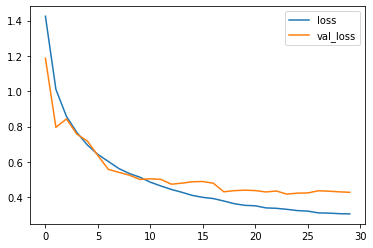

In [15]:
# Plot the cost function at each itteration
# Note: model.fit() returns an object that contains the history of the training process
plt.plot(result.history['loss'], label='loss');
plt.plot(result.history['val_loss'], label='val_loss');
plt.legend();

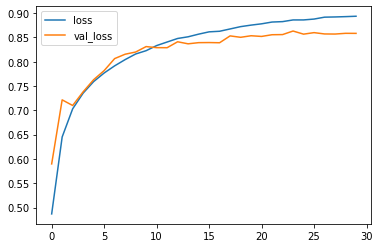

In [16]:
# Plot the cost function at each itteration
# Note: model.fit() returns an object that contains the history of the training process
plt.plot(result.history['accuracy'], label='loss');
plt.plot(result.history['val_accuracy'], label='val_loss');
plt.legend();

Confusion matrix, without Normalization
[[880  18  26   5   8   3   9   3  33  15]
 [  5 961   0   0   1   1   0   0   4  28]
 [ 40   6 789  21  37  33  52  13   4   5]
 [ 15   5  40 669  34 115  68  26  10  18]
 [  7   1  37  12 839  13  58  26   7   0]
 [  4   3  23  89  29 781  27  36   1   7]
 [  4   1  25  15   3   5 938   4   4   1]
 [ 10   2  14  14  36  23   3 890   3   5]
 [ 30  23   6   3   0   3   4   0 915  16]
 [  9  49   1   6   0   1   0   2  10 922]]


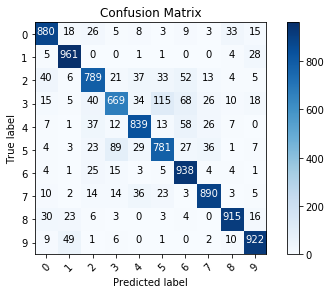

In [17]:
# Plot confusion matrix
p_test = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(K)))

In [18]:
# Print summary of model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496 